In [1]:
import pandas as pd 
from matplotlib import pyplot as plt
import os
import cv2
import numpy as np
from matplotlib.pyplot import figure
import scipy.io
from  scipy.interpolate import interp1d
plt.rcParams['figure.figsize'] == [10,10]
plt.rcParams.update({'font.size' : 18})

In [2]:
face_codes = scipy.io.loadmat('face_codes.mat')
ufaces = face_codes['ufaces']

In [3]:
yalefaces = scipy.io.loadmat('yalefaces.mat')
yalefaces = yalefaces['yalefaces']

In [4]:
yalefaces.shape

(48, 42, 2414)

In [9]:
ufaces[0:5]

array([[  1,   1,  64,   1,   5],
       [  2,  65, 128,   2,   5],
       [  3, 129, 192,   1,   5],
       [  4, 193, 256,   1,   5],
       [  5, 257, 320,   2,   6]], dtype=uint16)

Change to python indexing

In [10]:
ufaces_df = pd.DataFrame(data=ufaces, columns=['face_id', 'first_img', 'last_img', 'race', 'gender'])

In [11]:
ufaces_df['face_id'] = ufaces_df['face_id'].apply(lambda x: x-1)
ufaces_df['first_img'] = ufaces_df['first_img'].apply(lambda x: x-1)
ufaces_df['last_img'] = ufaces_df['last_img'].apply(lambda x: x-1)


In [14]:
ufaces = np.array(ufaces_df)

In [15]:
ufaces[0:5]

array([[  0,   0,  63,   1,   5],
       [  1,  64, 127,   2,   5],
       [  2, 128, 191,   1,   5],
       [  3, 192, 255,   1,   5],
       [  4, 256, 319,   2,   6]])

In [20]:
ufaces.shape[0]

38

In [128]:
191 - 128

63

Get NN, RR, GG to create sublibraries

In [34]:
NN = np.zeros((1,2414))
RR = np.zeros((1,2414))
GG = np.zeros((1,2414))

for i in range(0, ufaces.shape[0]):
    NN[0, ufaces[i,1]:ufaces[i,2]+1] = i
    RR[0, ufaces[i,1]:ufaces[i,2]+1] = ufaces[i,3]
    GG[0, ufaces[i,1]:ufaces[i,2]+1] = ufaces[i,4]

NN = NN.squeeze()
RR = RR.squeeze()
GG = GG.squeeze()

In [139]:
np.count_nonzero(NN == 10)

60

In [50]:
target_person = 13
excluded_face = 26

In [62]:
target_image = ufaces[target_person,1]

In [76]:
target_image # -1 than what in matlab - this is python indexing 

819

(-0.5, 41.5, 47.5, -0.5)

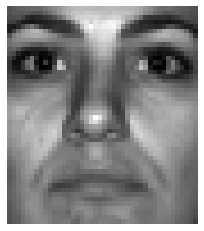

In [127]:
plt.imshow(yalefaces[:,:,819]).set_cmap('gray')
plt.axis('off')

In [251]:
C_minus_1_ind = np.where(np.logical_and(RR == 1, NN != excluded_face))
C_minus_T_ind = np.where(np.logical_and(RR == 1, NN != target_person))

In [225]:
C_minus_1_ind[0].shape

(1659,)

In [226]:
C_minus_T_ind[0].shape

(1660,)

In [227]:
C_minus_T_ind

(array([   0,    1,    2, ..., 2411, 2412, 2413]),)

In [252]:
LIB_C_minus_T = yalefaces[:,:,C_minus_T_ind].squeeze()
LIB_C_minus_1 = yalefaces[:,:,C_minus_1_ind].squeeze()

In [253]:
LIB_C_minus_T.shape

(48, 42, 1660)

In [254]:
LIB_C_minus_1.shape

(48, 42, 1659)

In [443]:
n = 430

(-0.5, 41.5, 47.5, -0.5)

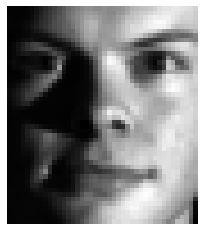

In [444]:
plt.imshow(LIB_C_minus_T[:,:,n]).set_cmap('gray')
plt.axis('off')


(-0.5, 41.5, 47.5, -0.5)

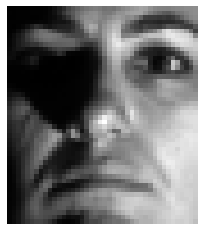

In [445]:
plt.imshow(LIB_C_minus_1[:,:,n]).set_cmap('gray')
plt.axis('off')

In [206]:
[h, w, n] = LIB_C_minus_T.shape

In [207]:
cutoff = 100

In [208]:
def reconstruct_face(C_FACES, target_image, cutoff):
    [h, w, n] = C_FACES.shape
    d = h * w
    x = np.reshape(C_FACES, [d, n])
    mean_matrix = x.mean(axis=1)
    tiled_mean = np.tile(mean_matrix, (x.shape[1], 1))
    tiled_mean = tiled_mean.T
    Xtrain = x - tiled_mean
    s = np.cov(Xtrain)
    eigval, eigvec = np.linalg.eig(s)
    eigval.sort()
    eigval = eigval[::-1]
    eigsum = sum(eigval)
    eigvec = eigvec[::-1]

    csum = 0
    for i in range(0,d):
        csum = csum + eigval[i]
        tv = csum / eigsum
        if tv > 0.95:
            k95 = i
            break

    FACE = yalefaces[:,:,target_image]
    FACE_reshaped = np.reshape(FACE, [1, 2016])
    FACE_PROJECTED = np.matmul(FACE_reshaped, eigvec)
    FACE_PROJECTED[cutoff:] = 0
    FACE_RECONSTRUCTED = np.matmul(FACE_PROJECTED, eigvec.T)

    return FACE_RECONSTRUCTED, eigvec, eigval, k95



In [209]:
FACE_RECONSTRUCTED_T, eigvec_T, eigval_T, k95_T = reconstruct_face(LIB_C_minus_T, target_image, cutoff)
FACE_RECONSTRUCTED_1, eigvec_1, eigval_1, k95_1 = reconstruct_face(LIB_C_minus_1, target_image, cutoff)

<ipython-input-446-83c962f07f05>:2: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.imshow(np.reshape(FACE_RECONSTRUCTED_1.astype(float), [h,w])).set_cmap('gray')


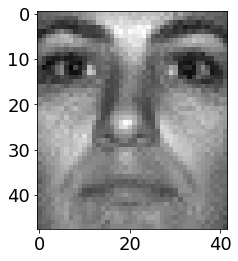

In [446]:
[h, w, n] = LIB_C_minus_1.shape
plt.imshow(np.reshape(FACE_RECONSTRUCTED_1.astype(float), [h,w])).set_cmap('gray')

<ipython-input-447-d5b90071ba0f>:2: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.imshow(np.reshape(FACE_RECONSTRUCTED_T.astype(float), [h,w])).set_cmap('gray')


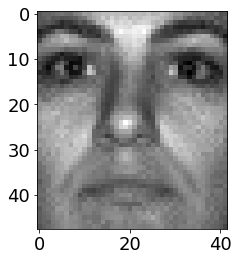

In [447]:
[h, w, n] = LIB_C_minus_T.shape
plt.imshow(np.reshape(FACE_RECONSTRUCTED_T.astype(float), [h,w])).set_cmap('gray')